In this notebook, we will create the network on which we will apply different interpretability techniques. We assume VGG16 as the basis and modify it in a way that it is adjusted to the new dataset.  

### Imports

In [2]:
# %tensorflow_version 2.x

import warnings
warnings.filterwarnings("ignore")

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_hub as hub

from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

### VGG16 Base Model

In this notebook, we are going to apply transfer learning on the famous [VGG16](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) network. The model's initial atchitecture is:

In [3]:
print(vgg16.VGG16().summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

None


### Loading the Dataset
The [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset from Tensorflow Dataset (TFDS) is used in this project. It has 23,262 images, 11,173 and 11,089 of which belonging to the cat and dog classes, respectively. After loading the dataset, we will set the BATCH_SIZE to 32, and split the images into train, test, val subsets.

In [4]:
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

# load the dataset given the splits defined above
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.KPNHJV_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [16]:
print("Number of samples: ", num_examples)
print(info)

Number of samples:  23262
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmp3p13_0fttfds'),
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell

In [19]:
print("Train len:\t{}".format(len(splits[0])))
print("Val len:\t{}".format(len(splits[1])))
print("Test set:\t{}".format(len(splits[2])))

Train len:	18610
Val len:	2326
Test set:	2326


In [20]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
print(f"Addition of two tuples sample:\t{IMAGE_SIZE + (3,)}")

# resizes the image and normalizes the pixel values
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return image, label

# prepare batches
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_examples.map(format_image).batch(1)

Addition of two tuples sample:	(224, 224, 3)


In [21]:
print(f"Number of train batches: {len(train_examples)} / {BATCH_SIZE} = {len(train_batches)} ~ {round(len(train_examples) / BATCH_SIZE, 3)}")
print(f"Number of val batches:   {len(validation_examples)} / {BATCH_SIZE} = {len(validation_batches)} ~ {round(len(validation_examples) / BATCH_SIZE, 3)}")

Number of train batches: 18610 / 32 = 582 ~ 581.562
Number of val batches:   2326 / 32 = 73 ~ 72.688


### Transfer Learning on VGG16
Now, we will apply subtle changes to the VGG16 network. We remove the model's top, which includes layers after MaxPooling2D. Layers before MaxPooling2D are freezed.


The MaxPooling2D layer itself is also replaced by a GlobalAveragePooing2D, according to the Class [Activation map](https://arxiv.org/pdf/1512.04150) paper's suggestion.



In [22]:
num_of_layers_fine_tuned = 4

def build_model():
  # load the base VGG16 model (Transfer Learning)
  base_model = vgg16.VGG16(input_shape=IMAGE_SIZE + (3,),
                      weights='imagenet',
                      include_top=False)

  # Fine-tune the model in a way that:
  # 1. Add a GlobalAveragePooling
  # 2. Batch Normalization
  # 3. A Dense(2) layer. 2 because there are 2 classes
  output = layers.GlobalAveragePooling2D()(base_model.output)
  output = layers.BatchNormalization()(output)
  output = layers.Dense(2, activation='softmax')(output)

  # set the inputs and outputs of the model
  final_model = Model(base_model.input, output)

  # freeze the earlier layers
  for layer in base_model.layers[:-num_of_layers_fine_tuned]:
      layer.trainable=False

  for trainable_layer in base_model.layers[-num_of_layers_fine_tuned:]:
      print(f"Layers to be trained (added for fine-tuning):\t{trainable_layer.name}")

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  final_model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  final_model.summary()

  return final_model

In [23]:
final_model = build_model()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Layers to be trained (added for fine-tuning):	block5_conv1
Layers to be trained (added for fine-tuning):	block5_conv2
Layers to be trained (added for fine-tuning):	block5_conv3
Layers to be trained (added for fine-tuning):	block5_pool


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,0

 Total params: 14,717,762 (56.14 MB)

 Trainable params: 7,081,474 (27.01 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

In [24]:
EPOCHS = 4
final_model.fit(train_batches,
          epochs=EPOCHS,
          validation_data=validation_batches)

Epoch 1/4
582/582 ━━━━━━━━━━━━━━━━━━━━ 141s 201ms/step - accuracy: 0.8777 - loss: 0.2914 - val_accuracy: 0.9497 - val_loss: 0.1192
Epoch 2/4
582/582 ━━━━━━━━━━━━━━━━━━━━ 104s 169ms/step - accuracy: 0.9506 - loss: 0.1232 - val_accuracy: 0.9553 - val_loss: 0.1183
Epoch 3/4
582/582 ━━━━━━━━━━━━━━━━━━━━ 140s 166ms/step - accuracy: 0.9625 - loss: 0.0967 - val_accuracy: 0.9604 - val_loss: 0.1204
Epoch 4/4
582/582 ━━━━━━━━━━━━━━━━━━━━ 106s 170ms/step - accuracy: 0.9773 - loss: 0.0652 - val_accuracy: 0.9553 - val_loss: 0.1323


### Save Model

Finally, we will save the trained model and use it in other notebooks. It is also a good idea to reload the model and test if everything is correct.

In [25]:
final_model.save('VGG16_transfer_learning.h5')

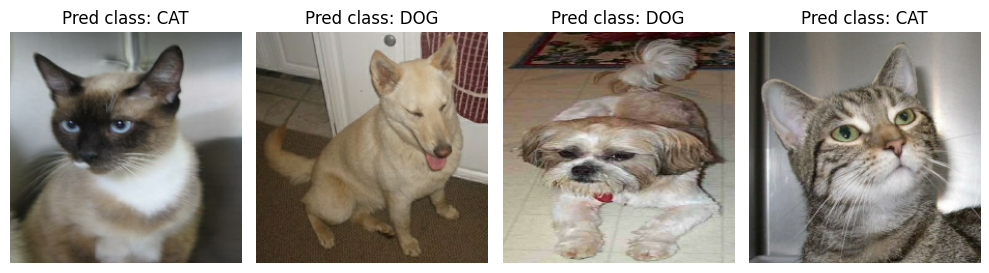

In [39]:
# Testing the model
test_model = tf.keras.models.load_model("VGG16_transfer_learning.h5", compile=False)

f, axs = plt.subplots(1, 4, figsize = (10, 5))
count = 0
for img, label in test_batches.take(4):
  pred = test_model(img)
  pred = pred[0].numpy()
  if pred[0] >= pred[1]:
    pred_class = 'CAT'
  else:
    pred_class = 'DOG'
  axs[count].imshow(img[0])
  axs[count].axis('off')
  axs[count].set_title('Pred class: ' + pred_class)
  count += 1

plt.tight_layout()
plt.grid(False)
plt.axis('off')
plt.show()